In [3]:
import pandas as pd
import glob
import os
# import keras.applications.efficientnet as efc
from tensorflow.python.keras.applications.efficientnet import *
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from tqdm import tqdm
print(tf.__version__)

Using TensorFlow backend.


2.3.0


In [4]:
# conda install matplotlib

In [5]:
# conda install tensorflow==2.3.0

In [6]:
# conda search cudnn

In [7]:
# conda install cudnn=7.6.5=cuda10.1_0

In [8]:
# check if tensorflow see the GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
# check name of GPU
!nvidia-smi

Mon Jun 27 06:01:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P2    34W /  N/A |   1195MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
#читаем датасет
df = pd.read_csv('MO MI images - imagesAndNames.csv')
df

,image,name,created,license,rightsHolder
0,https://mushroomobserver.org/images/640/2.jpg,Xylaria magnoliae,2004-07-17,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
1,https://mushroomobserver.org/images/640/16.jpg,Volvopluteus gloiocephalus,2005-01-07,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
2,https://mushroomobserver.org/images/640/26.jpg,Panellus stipticus,2004-11-26,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
3,https://mushroomobserver.org/images/640/36.jpg,Sutorius eximius,2004-07-14,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
4,https://mushroomobserver.org/images/640/37.jpg,Harrya chromapes,1994-09-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
...,...,...,...,...,...
254917,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254918,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254919,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254920,NaN,NaN,NaN,NaN,NaN


In [11]:
# Получаем список фото, которые у нас имеются на данный момент
jpgFilenamesList = glob.glob('./data_ideal/*.jpg')
photos = []
for i in jpgFilenamesList:
    photos.append(int((os.path.basename(i))[:-4]))

In [12]:
# Перекраиваем датасет под имеющиеся у нас фото
df_exist_photos = df[df.index.isin(photos)]

In [13]:
df_exist_photos

,image,name,created,license,rightsHolder
0,https://mushroomobserver.org/images/640/2.jpg,Xylaria magnoliae,2004-07-17,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
1,https://mushroomobserver.org/images/640/16.jpg,Volvopluteus gloiocephalus,2005-01-07,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
2,https://mushroomobserver.org/images/640/26.jpg,Panellus stipticus,2004-11-26,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
3,https://mushroomobserver.org/images/640/36.jpg,Sutorius eximius,2004-07-14,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
4,https://mushroomobserver.org/images/640/37.jpg,Harrya chromapes,1994-09-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
...,...,...,...,...,...
249995,https://mushroomobserver.org/images/640/128218...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller
249996,https://mushroomobserver.org/images/640/128252...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller
249997,https://mushroomobserver.org/images/640/128217...,Panus conchatus,2020-11-21,http://creativecommons.org/licenses/by-nc-sa/3.0/,Randy Longnecker
249998,https://mushroomobserver.org/images/640/128217...,Panus conchatus,2020-11-21,http://creativecommons.org/licenses/by-nc-sa/3.0/,Randy Longnecker


In [18]:
families = df_exist_photos['name'].str.split(n=1).str[0].value_counts()
families

Psilocybe        9213
Amanita          8455
Russula          7217
Cortinarius      5193
Mycena           4509
                 ... 
Spadicoides         1
Atelocauda          1
Cerogenes           1
Blumenavia          1
Sporidiobolus       1
Name: name, Length: 1561, dtype: int64

In [52]:
# Составим топ-1000 семейств в имеющимся у нас датасете
families = df_exist_photos['name'].str.split(n=1).str[0].value_counts()[:20]
families
#1

Psilocybe       9213
Amanita         8455
Russula         7217
Cortinarius     5193
Mycena          4509
Lactarius       3664
Agaricus        2823
Tricholoma      2779
Suillus         2549
Boletus         2474
Entoloma        2451
Inocybe         2333
Trametes        2248
Ganoderma       2134
Psathyrella     2003
Cantharellus    1958
Pluteus         1705
Hygrophorus     1699
Armillaria      1520
Galerina        1482
Name: name, dtype: int64

In [53]:
# Рассмотрим сколько фотографий топ-1000 семейств имеется
families.sum()
#2

68409

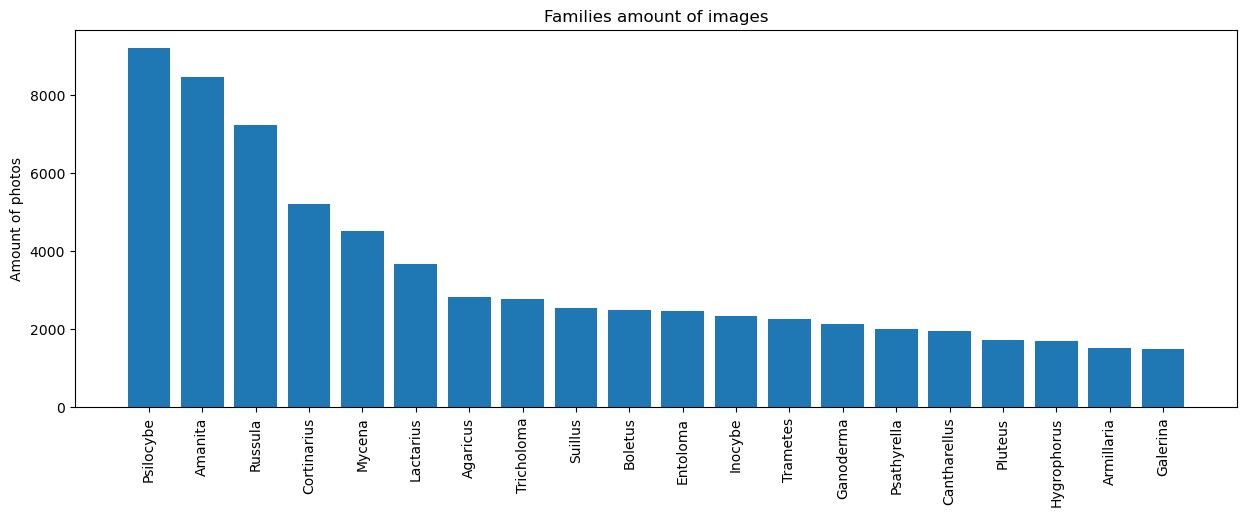

In [54]:
fig, axes = plt.subplots(figsize=(15,5), dpi=100)
plt.bar(families.index, height=families)
plt.xticks(rotation=90)
plt.title('Families amount of images')
plt.ylabel('Amount of photos')
plt.savefig('Families_amount_of_images.png', bbox_inches='tight')
plt.show()

In [39]:
# Составим датасет, состоящий только из топ-100 грибных семейств
top_1000 = df_exist_photos[df_exist_photos['name'].str.split(n=1).str[0].isin(families.index)]
top_1000

,image,name,created,license,rightsHolder
24,https://mushroomobserver.org/images/640/107.jpg,Russula virescens,2004-07-14,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
25,https://mushroomobserver.org/images/640/111.jpg,Russula cremoricolor,2002-01-09,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
26,https://mushroomobserver.org/images/640/125.jpg,Russula aeruginea,2004-11-22,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
36,https://mushroomobserver.org/images/640/240.jpg,Mycena leaiana,1994-09-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
37,https://mushroomobserver.org/images/640/253.jpg,Amanita vernicoccora,1993-06-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
...,...,...,...,...,...
249992,https://mushroomobserver.org/images/640/128218...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller
249993,https://mushroomobserver.org/images/640/128218...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller
249994,https://mushroomobserver.org/images/640/128218...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller
249995,https://mushroomobserver.org/images/640/128218...,Mycena amicta,2020-11-23,http://creativecommons.org/licenses/by-sa/3.0/,Alan Rockefeller


In [40]:
# Оставим в датасете только всё самое необходимое: индекс и имя семейства, а также удалим пустое
top_1000 = top_1000.rename_axis('index').reset_index()
top_1000 = top_1000[['index', 'name']]
top_1000.dropna(inplace=True)
top_1000[:10]

,index,name
0,24,Russula virescens
1,25,Russula cremoricolor
2,26,Russula aeruginea
3,36,Mycena leaiana
4,37,Amanita vernicoccora
5,107,Amanita protecta
6,108,Amanita protecta
7,109,Amanita phalloides
8,110,Amanita phalloides
9,111,Amanita phalloides


In [73]:
### Раскидаем картинки этого датасета по директориям

for family in tqdm(families.index):
    os.mkdir(f"data_train/{family}")
    for idx, row in top_1000[top_1000['name'].str.split(n=1).str[0] == family].iterrows():
        shutil.copy(f'data_ideal/{row["index"]}.jpg', f'data_train/{family}/{row["index"]}.jpg')

In [42]:
# # Имя семейства это категориальный признак, поэтому делаем LAbelEncoding
# kek = pd.get_dummies(top_10[['name']])
# top_10 = pd.concat([top_10, kek], axis=1)
# top_10

In [43]:
# разделим набор данных train, validation
# train, test = train_test_split(top_10, test_size=0.2, stratify=kek)

In [44]:
# train

In [45]:
# test

In [46]:
# Создадим модель import tensorflow as tf
IMG_SIZE = 224
def build_model(num_classes, img_size=IMG_SIZE):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="EfficientNet")
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy", "sparse_categorical_crossentropy"])
    return model

In [47]:
#
def use_keras_new(path):
    keras_ds = tf.keras.preprocessing.image_dataset_from_directory(path, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_ds = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # keras_ds = keras_ds.prefetch(buffer_size=1000)

    num_classes = len(os.listdir(path))
    model = build_model(num_classes)

    history = model.fit(keras_ds, batch_size=32, epochs=10)
    model.save('model.h5')
    return model, history

In [48]:
#
def use_keras(path_learn, path_valid):
    keras_ds = tf.keras.preprocessing.image_dataset_from_directory(path_learn, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_ds = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # keras_ds = keras_ds.prefetch(buffer_size=1000)

    num_classes = len(os.listdir(path_learn))
    model = build_model(num_classes)

    keras_validate = tf.keras.preprocessing.image_dataset_from_directory(path_valid, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_validate = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    history = model.fit(keras_ds, batch_size=32, epochs=20, validation_data=keras_validate)
    model.save('model_valid.h5')
    return model, history

In [72]:
model, history = use_keras_new('data_train')

In [55]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [1]:
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.plot(history.history['sparse_categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'],
#          label='Доля верных ответов на проверочном наборе')
plt.xlabel('Number of epoch', fontsize=13)
plt.ylabel('Accuracy, %', fontsize=13)
plt.title('Sparce categorical accuracy', fontsize=13)
plt.savefig('Sparce_categorical_accuracy.png', bbox_inches='tight')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

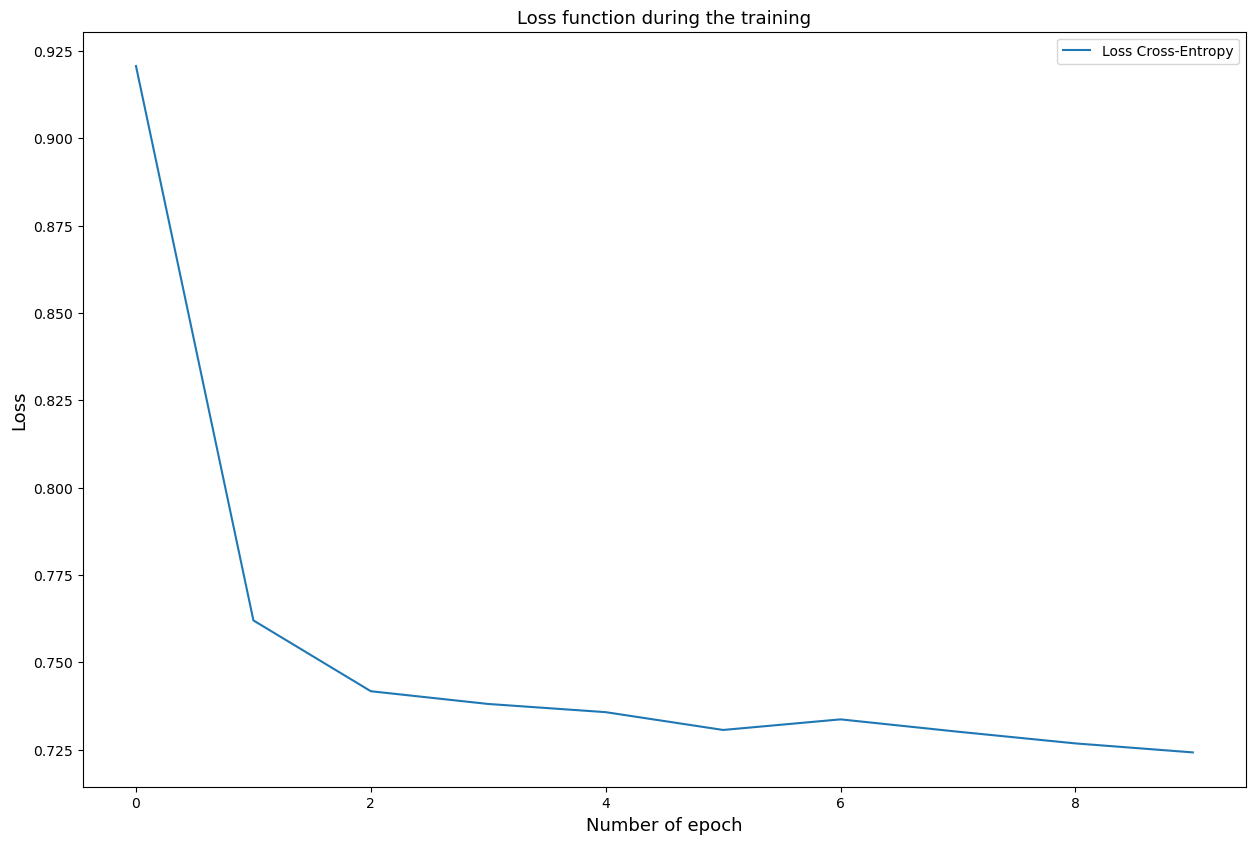

In [70]:
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.plot(history.history['loss'],
         label='Loss Cross-Entropy')
# plt.plot(history.history['val_categorical_accuracy'],
#          label='Доля верных ответов на проверочном наборе')
plt.xlabel('Number of epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Loss function during the training', fontsize=13)
plt.savefig('loss.png', bbox_inches='tight')
plt.legend()
plt.show()

In [62]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy'])

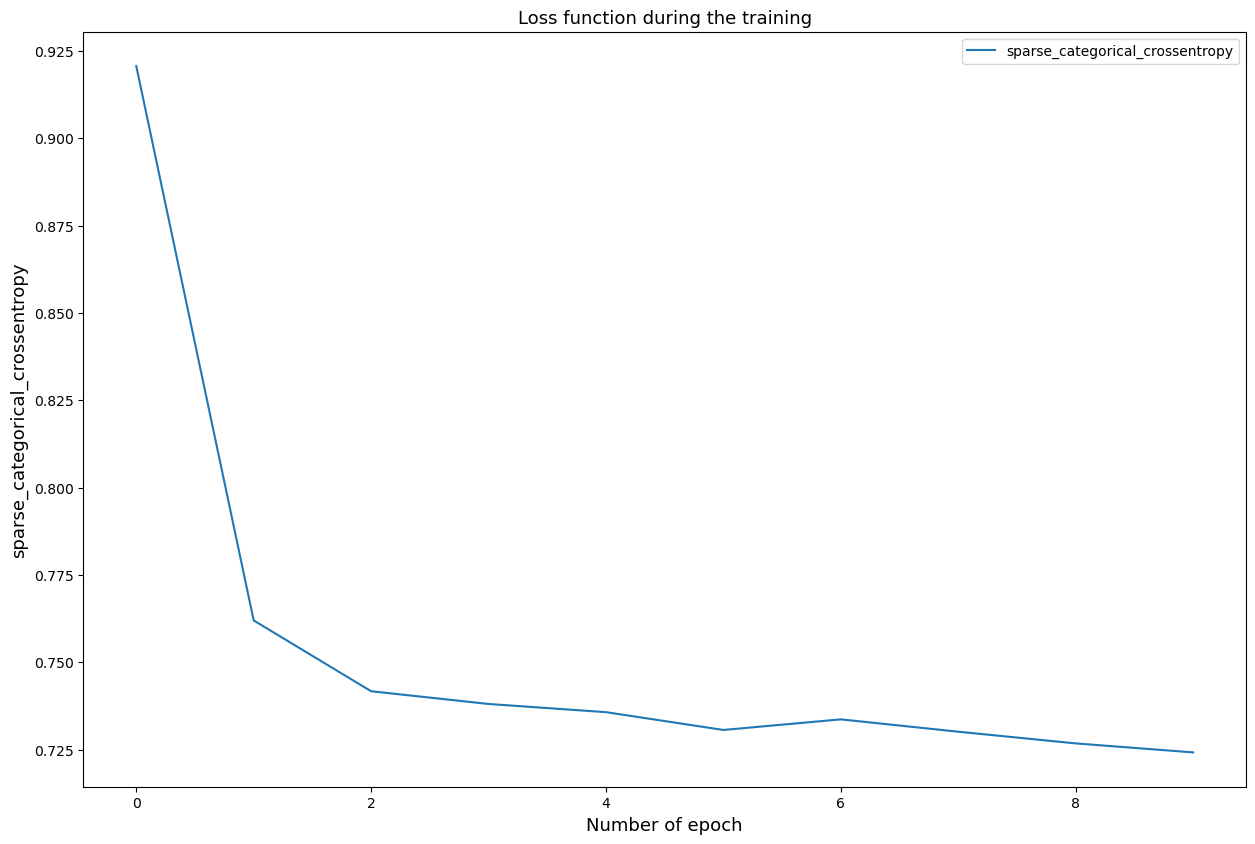

In [74]:
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.plot(history.history['sparse_categorical_crossentropy'],
         label='sparse_categorical_crossentropy')
# plt.plot(history.history['val_categorical_accuracy'],
#          label='Доля верных ответов на проверочном наборе')
plt.xlabel('Number of epoch', fontsize=13)
plt.ylabel('sparse_categorical_crossentropy', fontsize=13)
plt.title('Loss function during the training', fontsize=13)
plt.savefig('sparse_categorical_crossentropy.png', bbox_inches='tight')
plt.legend()
plt.show()